## Segment anything models

Using a segment anything model, you can give it prompts to finetuning what you want to extract
- You can give it multiple points, with positive or negative values (do you want to include or not)
- You can give it bounding boxes

In [52]:
from PIL import Image
from utils.segmentation_utils import resize_image, show_points_on_image, show_masks_on_image
from utils.segmentation_utils import format_results, point_prompt, box_prompt
import torch
from ultralytics import YOLO


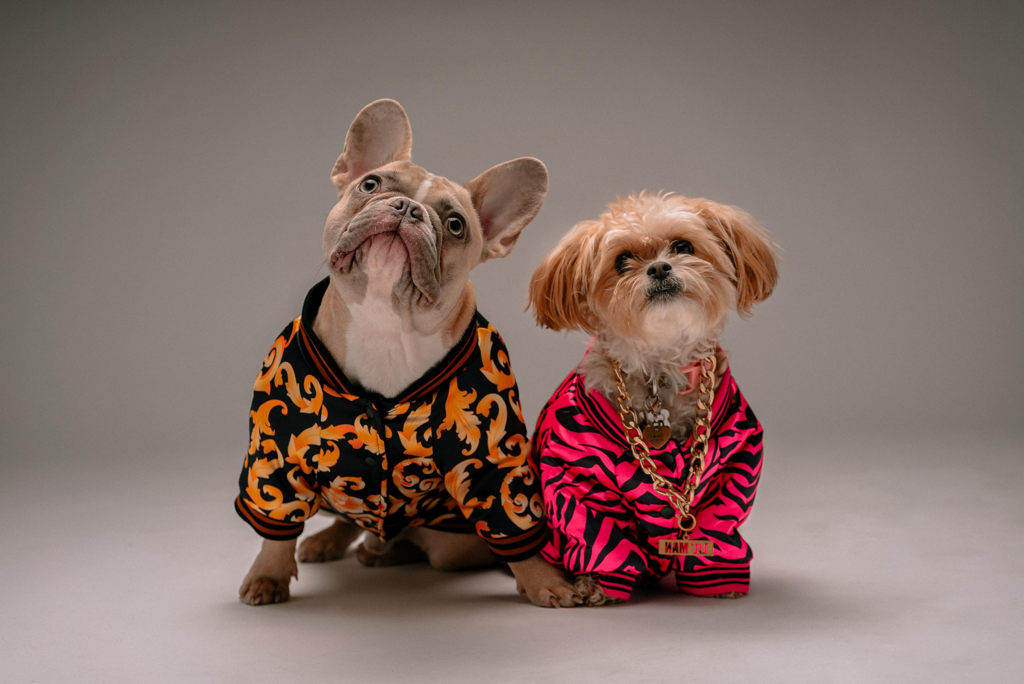

In [53]:
raw_image = Image.open("/Users/louis.takumi@dataiku.com/Documents/code/perso/image_gen/data/dogs.jpg")
resized_image = resize_image(raw_image, input_size=1024)
resized_image

In [67]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
path2sam = '/Users/louis.takumi@dataiku.com/Documents/code/perso/image_gen/models/dlai_comet_FastSAM.pt'
model = YOLO(path2sam)

In [55]:
results = model(resized_image, device=device, retina_masks=True)


0: 704x1024 23 objects, 1937.0ms
Speed: 6.5ms preprocess, 1937.0ms inference, 66.3ms postprocess per image at shape (1, 3, 704, 1024)


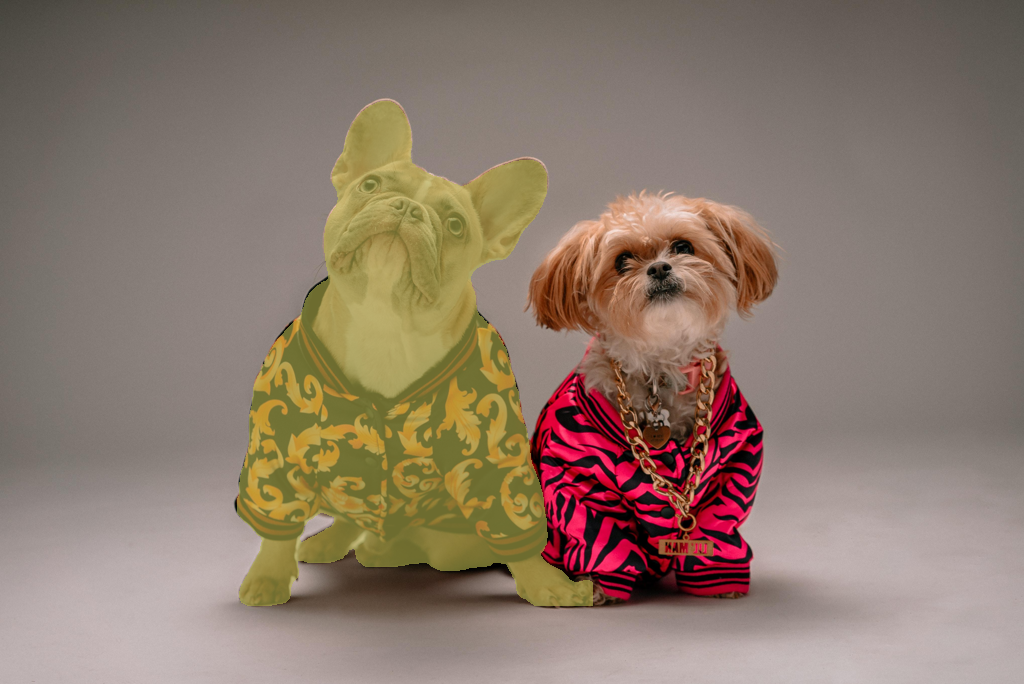

In [56]:
# Define the coordinates for the point in the image
input_points = [ [350, 450 ] ]
input_labels = [1] # positive point

# format results, extract mask and visualize
results_formatted = format_results(results[0], 0)
masks, _ = point_prompt(results_formatted, input_points, input_labels)
show_masks_on_image(resized_image, [masks])

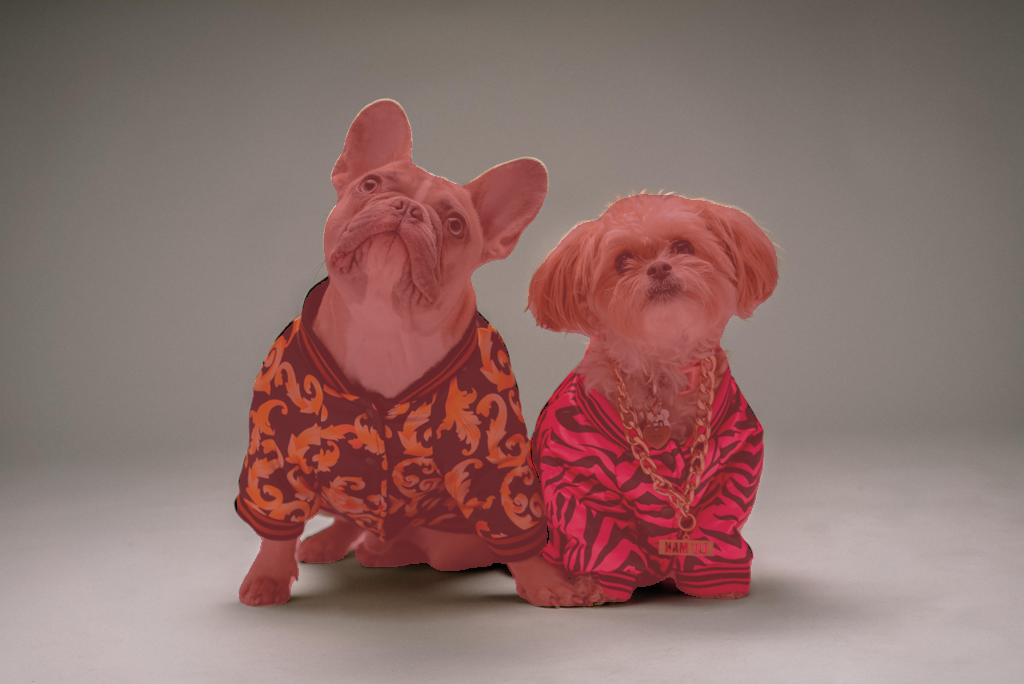

In [57]:
# Specify two points in the same image
input_points = [ [350, 450], [620, 450] ]
input_labels = [1 , 1] # both positive points

# format results, extract mask and visualize
results_formatted = format_results(results[0], 0)
masks, _ = point_prompt(results_formatted, input_points, input_labels)
show_masks_on_image(resized_image, [masks])

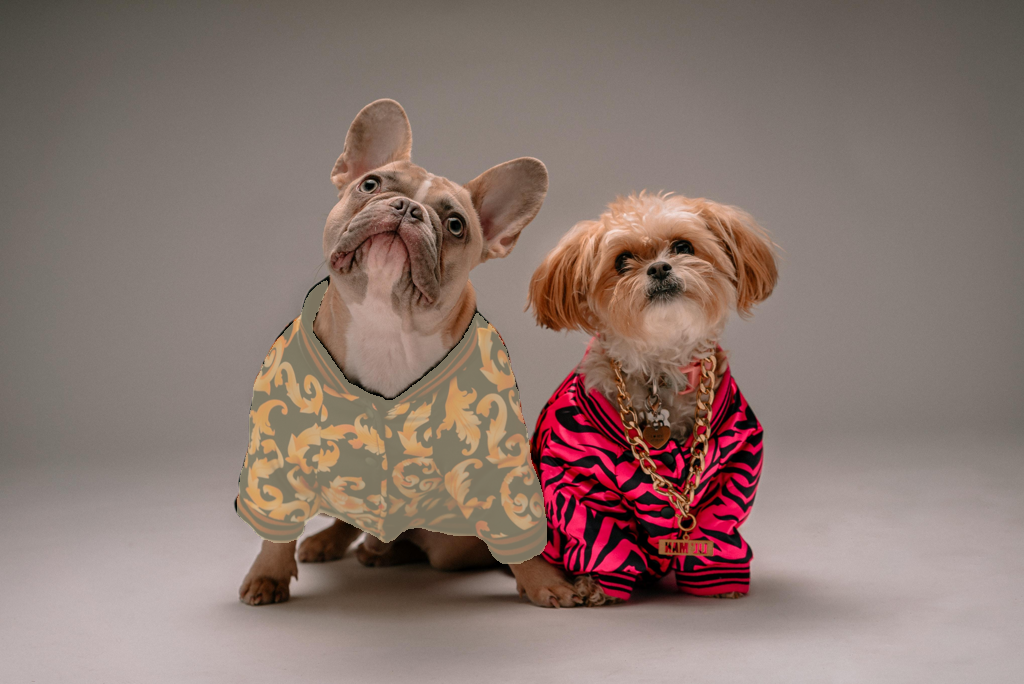

In [58]:
# negative prompt example
input_points = [ [350, 450], [400, 300]  ]
input_labels = [1, 0] # positive prompt, negative prompt

# format results, extract mask and visualize
results_formatted = format_results(results[0], 0)
masks, _ = point_prompt(results_formatted, input_points, input_labels)
show_masks_on_image(resized_image, [masks])

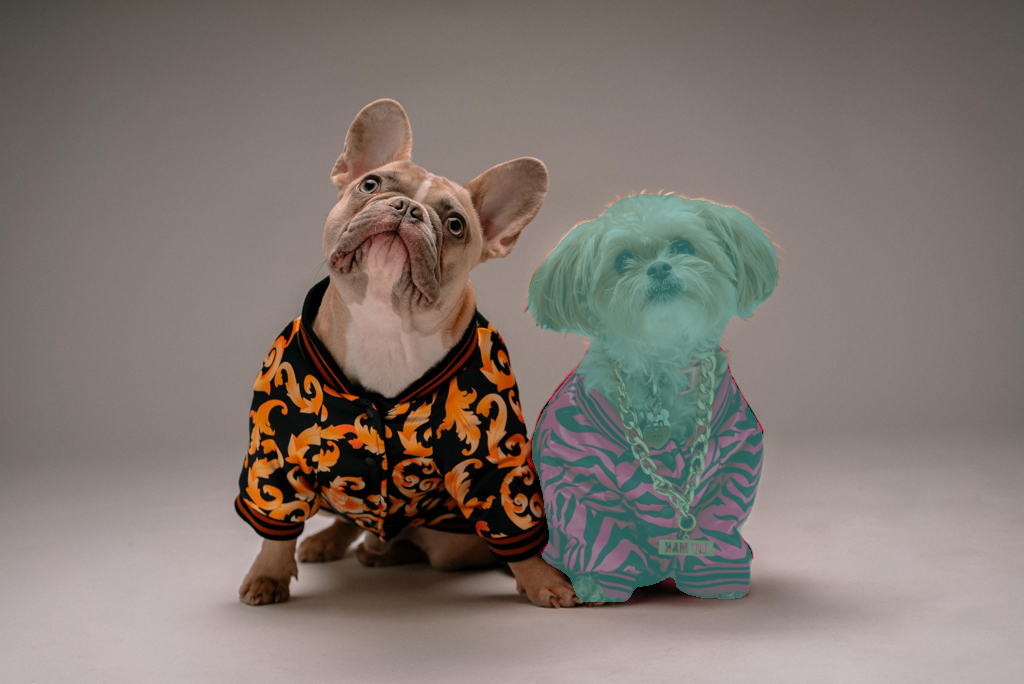

In [35]:
# Set the bounding box coordinates
# [xmin, ymin, xmax, ymax]
input_boxes = [530, 180, 780, 600]

masks = results[0].masks.data > 0
masks, _ = box_prompt(masks, input_boxes)
show_masks_on_image(resized_image, [masks])

## Text to object detection

Using this model : https://huggingface.co/docs/transformers/en/model_doc/owlvit

In [45]:
from transformers import pipeline
from utils.objectdetection_utils import show_boxes_and_labels_on_image, preprocess_outputs

In [39]:
# load model
detector = pipeline(
    model="google/owlvit-base-patch32",
    task="zero-shot-object-detection"
)

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [40]:
# What you want to identify in the image
text_prompt = "dog"
output = detector(
    raw_image,
    candidate_labels = [text_prompt]
)
output

[{'score': 0.18635611236095428,
  'label': 'dog',
  'box': {'xmin': 888, 'ymin': 388, 'xmax': 2279, 'ymax': 2436}},
 {'score': 0.16987863183021545,
  'label': 'dog',
  'box': {'xmin': 2023, 'ymin': 727, 'xmax': 3112, 'ymax': 2434}}]

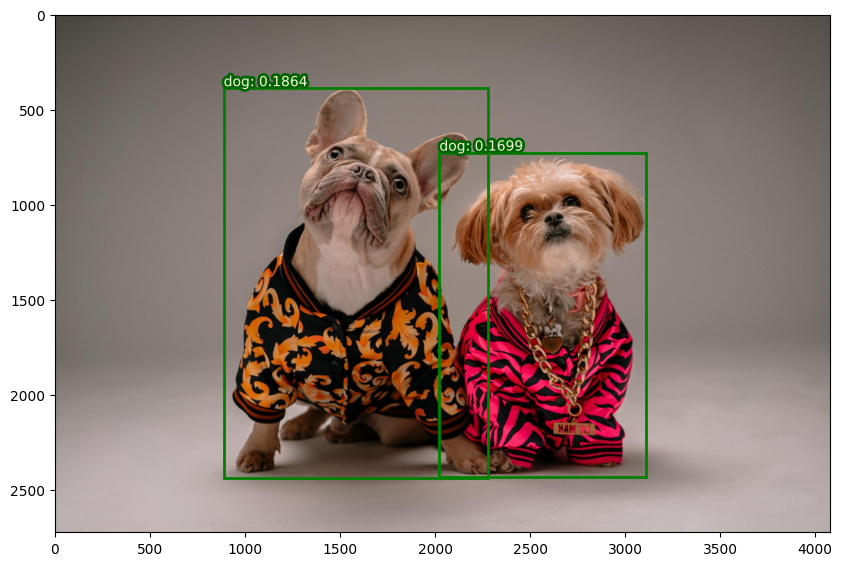

In [46]:
# Show the image with the bounding boxes
input_scores, input_labels, input_boxes = preprocess_outputs(output)

show_boxes_and_labels_on_image(
    raw_image,
    input_boxes[0],
    input_labels,
    input_scores
)

In [36]:
import requests
from PIL import Image
import torch

from transformers import OwlViTProcessor, OwlViTForObjectDetection

processor = OwlViTProcessor.from_pretrained("google/owlvit-base-patch32")
model = OwlViTForObjectDetection.from_pretrained("google/owlvit-base-patch32")

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)
texts = [["a photo of a cat", "a photo of a dog"]]
inputs = processor(text=texts, images=image, return_tensors="pt")
outputs = model(**inputs)

# Target image sizes (height, width) to rescale box predictions [batch_size, 2]
target_sizes = torch.Tensor([image.size[::-1]])
# Convert outputs (bounding boxes and class logits) to Pascal VOC format (xmin, ymin, xmax, ymax)
results = processor.post_process_object_detection(outputs=outputs, target_sizes=target_sizes, threshold=0.1)
i = 0  # Retrieve predictions for the first image for the corresponding text queries
text = texts[i]
boxes, scores, labels = results[i]["boxes"], results[i]["scores"], results[i]["labels"]
for box, score, label in zip(boxes, scores, labels):
    box = [round(i, 2) for i in box.tolist()]
    print(f"Detected {text[label]} with confidence {round(score.item(), 3)} at location {box}")

preprocessor_config.json:   0%|          | 0.00/392 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/775 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.42k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/613M [00:00<?, ?B/s]

Detected a photo of a cat with confidence 0.707 at location [324.97, 20.44, 640.58, 373.29]
Detected a photo of a cat with confidence 0.717 at location [1.46, 55.26, 315.55, 472.17]


## Combine the two = segment from text (in this case bluring faces)

You can finetune quite a bit, in this version we blur all faces, but you could identify the sunglasses to only blur people with no sunglasses.

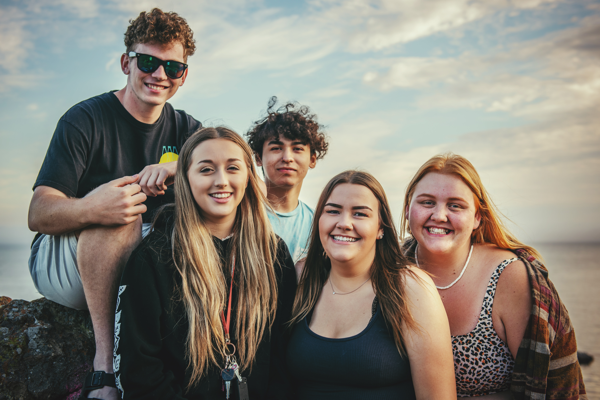

In [64]:
# load image and resize it
path2img = "data/people.jpg"
path2resize = "data/people_resized.jpg"
image = Image.open(path2img)

target_width = 600
target_height = int(target_width * image.size[1] / image.size[0])
raw_image = image.resize([target_width, target_height])
raw_image.save(path2resize)
raw_image

In [61]:
# Apply detector model to the raw image
labels = ["human face"]
output = detector(
    raw_image,
    candidate_labels=labels
)

In [71]:
# get segmentation mask of human faces
import numpy as np
from ultralytics import SAM

path2sam = '/Users/louis.takumi@dataiku.com/Documents/code/perso/image_gen/models/dlai_mobile_sam.pt'
model = SAM(path2sam)

# use this as input to SAM 
input_scores, input_labels, input_boxes = preprocess_outputs(output)
result = model.predict(
    path2resize,
    bboxes=input_boxes[0],
    labels=np.repeat(1, len(input_boxes[0]))
)


image 1/1 /Users/louis.takumi@dataiku.com/Documents/code/perso/image_gen/data/people_resized.jpg: 1024x1024 1 0, 1 1, 1 2, 1 3, 1 4, 889.2ms
Speed: 8.9ms preprocess, 889.2ms inference, 3.8ms postprocess per image at shape (1, 3, 1024, 1024)


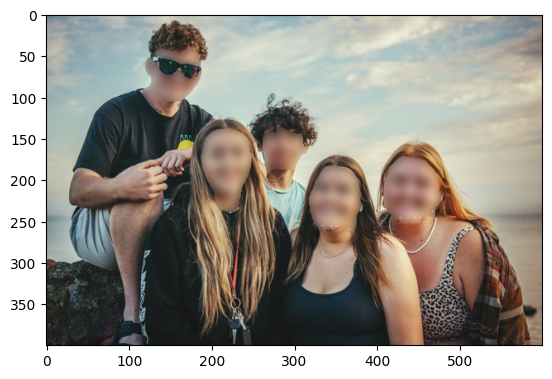

In [73]:
from PIL.ImageFilter import GaussianBlur
import matplotlib.pyplot as plt

# blur the image except where mask is negative
blurred_img = raw_image.filter(GaussianBlur(radius=5))

masks = result[0].masks.data.cpu().numpy()
total_mask = np.zeros(masks[0].shape)
for mask in masks:
    total_mask = np.add(total_mask,mask)
output = np.where(
    np.expand_dims(total_mask != 0, axis=2),
    blurred_img,
    raw_image
)

# Print image with faces blurred
plt.imshow(output)